In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

with h5py.File('train_catvnoncat.h5', 'r') as file:
    train_set_x = file['train_set_x'][:]
    train_set_y = file['train_set_y'][:]


with h5py.File('test_catvnoncat.h5', 'r') as file:
    test_set_x = file['test_set_x'][:]
    test_set_y = file['test_set_y'][:]



classes=np.unique(train_set_y)

m_train=train_set_x.shape[0]
m_test=test_set_x.shape[0]
num_px=train_set_x.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 1)")
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_X=train_set_x.reshape(-1,m_train)
test_set_X=test_set_x.reshape(-1,m_test)
y_train=train_set_y.reshape(1,m_train)
y_test=test_set_y.reshape(1,m_test)

train_set_X=train_set_X/255.0
test_set_X=test_set_X/255.0


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 1)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50,)


In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [5]:
class LogisticRegressionMBAdam():
    def __init__(self,X,y,epochs,batch_size,beta1=0.9,beta2=0.99,epsilon=10**-8,learning_rate=0.001):
        self.m=X.shape[1]
        dim=X.shape[0]
        self.X=X
        self.y=y
        self.w=np.zeros((dim,1))
        self.b=0
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.Vw=np.zeros(self.w.shape)
        self.Vb=0
        self.Sw=np.zeros(self.w.shape)
        self.Sb=0
        self.beta1=beta1
        self.beta2=beta2
        self.epsilon=epsilon

    def forward(self,x_batch,y_batch):
        Z=np.dot(self.w.T,x_batch)+self.b
        A=sigmoid(Z)

        cost=-np.sum((y_batch*np.log(A))+((1-y_batch)*np.log(1-A)))/x_batch.shape[1]
        return Z,A,cost

    def backward(self,A,x_batch,y_batch):
        dZ=A-y_batch
        db=np.sum(dZ)/x_batch.shape[1]
        dw=np.dot(x_batch,dZ.T)/x_batch.shape[1]
        return dw,db

    def main(self):
        cost_list=[]
        accuracy_list=[]
        no_of_batches=int(np.ceil(self.m/self.batch_size))
       
        for n in range(1,self.epochs+1):
            indices=np.arange(self.m)
            np.random.shuffle(indices)
            x_shuffled=self.X[:,indices]
            y_shuffled=self.y[:,indices]
            cost_batch=[]
            acc_batch=[]
            for batch in range(no_of_batches):
                start=batch*self.batch_size
                end=min((batch+1)*self.batch_size,self.m)
                x_batch=x_shuffled[:,start:end]
                y_batch=y_shuffled[:,start:end]
                Z,A,cost=self.forward(x_batch,y_batch)
                dw,db=self.backward(A,x_batch,y_batch)
                self.Vw = self.beta1 * self.Vw + (1 - self.beta1) * dw
                self.Vb = self.beta1 * self.Vb + (1 - self.beta1) * db
                self.Sw = self.beta2 * self.Sw + (1 - self.beta2) * (dw * dw)
                self.Sb = self.beta2 * self.Sb + (1 - self.beta2) * (db * db)

                Vw_corrected = self.Vw / (1 - self.beta1 ** n)
                Vb_corrected = self.Vb / (1 - self.beta1 ** n)
                Sw_corrected = self.Sw / (1 - self.beta2 ** n)
                Sb_corrected = self.Sb / (1 - self.beta2 ** n)



                cost_batch.append(cost)
                y_pred = (A >= 0.5) * 1.0
                accuracy = accuracy_score(y_batch.flatten(), y_pred.flatten())
                acc_batch.append(accuracy)
                self.w -= self.learning_rate * (Vw_corrected / (np.sqrt(Sw_corrected) + self.epsilon))
                self.b -= self.learning_rate * (Vb_corrected / (np.sqrt(Sb_corrected) + self.epsilon))
            cost=np.mean(cost_batch)
            accuracy=np.mean(acc_batch)
            cost_list.append(cost)
            accuracy_list.append(accuracy)
            print(f'Epoch {n} - loss: {cost}, accuracy: {accuracy}')
        plt.plot(cost_list)
        plt.show()
        plt.plot(accuracy_list)
        plt.show()

    def predict(self,test):
        A=sigmoid(np.dot(self.w.T,test)+self.b)
        y_pred = (A >= 0.5) * 1.0
        return y_pred

In [6]:
lrba=LogisticRegressionMBAdam(train_set_X,y_train,2000,32)

Epoch 1 - loss: 1.2111512902162735, accuracy: 0.5422794117647058
Epoch 2 - loss: 1.084427845143521, accuracy: 0.582983193277311
Epoch 3 - loss: 0.703709045199148, accuracy: 0.6538865546218487
Epoch 4 - loss: 0.648180895259556, accuracy: 0.6727941176470589
Epoch 5 - loss: 0.6274045337705035, accuracy: 0.6276260504201681
Epoch 6 - loss: 0.6060215550757894, accuracy: 0.6733193277310924
Epoch 7 - loss: 0.6002883643936, accuracy: 0.673844537815126
Epoch 8 - loss: 0.6577962131860168, accuracy: 0.6281512605042018
Epoch 9 - loss: 0.6309072549196328, accuracy: 0.6247373949579832
Epoch 10 - loss: 0.5809844494108285, accuracy: 0.6940651260504201
Epoch 11 - loss: 0.5840602232282421, accuracy: 0.6530987394957982
Epoch 12 - loss: 0.587808829859373, accuracy: 0.6762079831932774
Epoch 13 - loss: 0.5790686267425421, accuracy: 0.6638655462184875
Epoch 14 - loss: 0.5522514277606053, accuracy: 0.6867121848739496
Epoch 15 - loss: 0.5523728847439535, accuracy: 0.7358193277310924
Epoch 16 - loss: 0.534714518

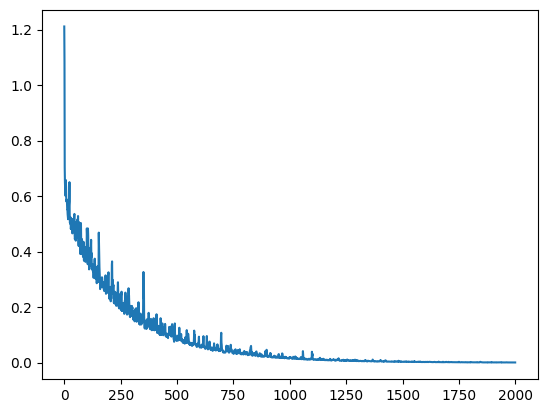

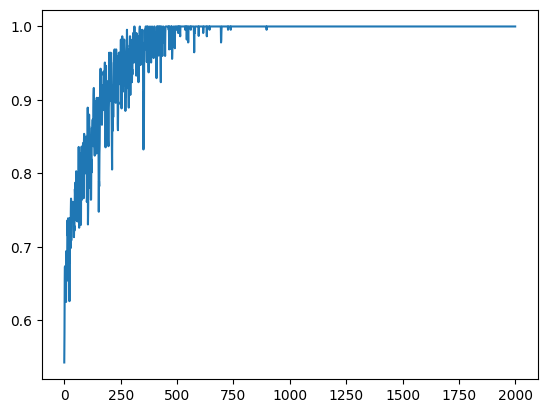

In [7]:
lrba.main()